In [8]:
Pkg.add("LibExpat"); using LibExpat
Pkg.add("Winston"); using Winston

# Pkg.clone("MXNet");
# ENV["MXNET_HOME"] = "/mxnet"

INFO: Package LibExpat is already installed
INFO: METADATA is out-of-date — you may not have the latest version of LibExpat
INFO: Use `Pkg.update()` to get the latest versions of your packages
INFO: Package Winston is already installed
INFO: METADATA is out-of-date — you may not have the latest version of Winston
INFO: Use `Pkg.update()` to get the latest versions of your packages


In [245]:
# using MXNet
using GraphPlot
using PyPlot
using PyCall
using StatsBase
using DataFrames
using CSV

In [2]:
using LightGraphs
import LightGraphs.SimpleGraphs: SimpleEdge, SimpleDiGraph
include("CreateOSMGraphs.jl")
using CreateOSMGraphs;
include("utils.jl")

INFO: Precompiling module Cairo.
INFO: Precompiling module IniFile.

Use "const Styles = @compat Union{Style,Dict{Int,Style}}" instead.


generate_weights_with_factors (generic function with 1 method)

### Load the map data

In [3]:
# osm_fn = "northern_stockholm.osm"
osm_fn = "kista.osm"
@time graph, vprops, eprops, edgeDict, 
nodesLLA, highways, geohash2edgedict = CreateOSMGraphs.CreateOSMGraph(osm_fn);

getOSMData
  3.603530 seconds (8.83 M allocations: 400.218 MiB, 9.35% gc time)
intersections
  0.000346 seconds (1.51 k allocations: 186.500 KiB)
roadways
  0.029649 seconds (1.98 k allocations: 129.298 KiB)
segmentHighways
  0.645702 seconds (93.00 k allocations: 4.693 MiB)
createGraph
  0.482902 seconds (137.22 k allocations: 5.744 MiB, 4.55% gc time)
  8.964640 seconds (9.85 M allocations: 453.358 MiB, 4.56% gc time)


### Build the dictionary from graph node id to map node id

In [ ]:
graphNodeId2MapNodeId = Dict()

locs_x = Array{Float64, 1}(nv(graph))
locs_y = Array{Float64, 1}(nv(graph))

for (k, v) in sort(vprops, by=x->vprops[x])
    graphNodeId2MapNodeId[v] = k
    println(nodesLLA[k].coords.lat, ",", nodesLLA[k].coords.lon);
    
    locs_x[v] = nodesLLA[k].coords.lon
    locs_y[v] = nodesLLA[k].coords.lat
end

In [5]:
println(maximum(locs_x))
println(minimum(locs_x))
println(maximum(locs_y))
println(minimum(locs_y))

17.9832329
17.9324095
59.4164298
59.3940158


### Calculate important features of each graph edge

In [6]:
edge_weights = Dict()

for (edge, info_dict) in edgeDict
    
    # sunny/rainy/snowy     
    info_dict[:weather] = 0
    
    num_vehicles = Int(ceil(randexp()) * 10)
    info_dict[:num_vehicles] = num_vehicles
    
    # Randomize centrality within (0, 1)
    info_dict[:centrality] = rand()
    
    # Add rush hour information
    info_dict[:rush_hour] = 0
    
    # Add highway information
    info_dict[:is_highway] = haskey(highways, info_dict[:id])
    
    # Which day of the week
    info_dict[:day_of_week] = 0
    
    # Is holiday?
    info_dict[:is_holiday] = 0
    
    edge_weight = generate_weights_with_factors(info_dict)
    
    info_dict[:weight] = edge_weight
    edge_weights[(edge.src, edge.dst)] = edge_weight
end

max_edge_weight = maximum(values(edge_weights))
min_edge_weight = minimum(values(edge_weights))
println(max_edge_weight)
println(min_edge_weight)

58.5436477733696
0.0033751807087013756


In [7]:
num_nodes = nv(graph)
max_out_degree = maximum(outdegree(graph))

# generate distance matrix
g_distmx = fill(Inf, (num_nodes, num_nodes))

for (edge, info_dict) in edgeDict
    # normalize weights
    g_distmx[edge.src, edge.dst] = (info_dict[:weight] - min_edge_weight) / (max_edge_weight - min_edge_weight)
end

# calculate between centrality
node_centrality = betweenness_centrality(graph)

# normalize x y coordinates
x_min, x_max = minimum(locs_x), maximum(locs_x)
norm_locs_x = map(c -> (c - x_min) / (x_max - x_min), locs_x)

y_min, y_max = minimum(locs_y), maximum(locs_y)
norm_locs_y = map(c -> (c - y_min) / (y_max - y_min), locs_y);

### A plot of northern Stockholm road network

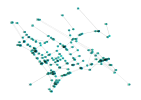

In [8]:
gplot(graph, locs_x, -locs_y, arrowlengthfrac=0.0, NODESIZE=0.02, nodelabel=1:num_nodes, NODELABELSIZE=2)

In [68]:
calc_cosine_dist(p1, p2) = dot(p1, p2) / (norm(p1) * norm(p2))

calc_euclidean_dist(p1, p2) = norm(p1 - p2)

function encode_edges(G, parent, node, src, dst)
    
    ret = fill(0.0, (max_out_degree, 14))
    
    x_u = norm_locs_x[node]
    y_u = norm_locs_y[node]
    x_dst = norm_locs_x[dst]
    y_dst = norm_locs_y[dst]

    for (idx, out_neighbor) in enumerate(outneighbors(G, node))
        
        out_neighbor == parent && continue
        
        x_v = norm_locs_x[out_neighbor]
        y_v = norm_locs_y[out_neighbor]
        
        ret[idx, 1] = edgeDict[Edge(node, out_neighbor)][:segmentlen]
        ret[idx, 2] = edgeDict[Edge(node, out_neighbor)][:speed]
        ret[idx, 3] = calc_euclidean_dist([x_v, y_v], [x_dst, y_dst])
        ret[idx, 4] = calc_cosine_dist([x_v-x_u, y_v-y_u], [x_dst-x_u, y_dst-y_u])
        ret[idx, 5] = x_v
        ret[idx, 6] = y_v
        ret[idx, 7] = edgeDict[Edge(node, out_neighbor)][:num_vehicles]
        ret[idx, 8] = edgeDict[Edge(node, out_neighbor)][:centrality]
        ret[idx, 9] = edgeDict[Edge(node, out_neighbor)][:rush_hour]
        ret[idx, 10] = edgeDict[Edge(node, out_neighbor)][:weather]
        ret[idx, 11] = float(edgeDict[Edge(node, out_neighbor)][:is_highway])
        ret[idx, 12] = edgeDict[Edge(node, out_neighbor)][:day_of_week]
        ret[idx, 13] = edgeDict[Edge(node, out_neighbor)][:is_holiday]
        ret[idx, end] = out_neighbor
        
    end
    
    return (ret, x_dst, y_dst)
    
end

encode_edges (generic function with 1 method)

In [69]:
function generate_stochastic_dataset(G; sample_size_lower_bound=100, verbose_frequent=10)
    
    pair_path_dict = Dict()
    sample_cnt = 0
    X = []
    y = []
    
    while true
        src = rand(1:num_nodes)
        dst = rand(1:num_nodes)
        
        src == dst && continue
        
        (src, dst) in keys(edge_weights) && continue    
        
        for (src, dst) in [(src, dst), (dst, src)]
    
            path = a_star(graph, src, dst, g_distmx)
            
            length(path) == 0 && continue
            
            pair_path_dict[(src, dst)] = path
            
            parent_node = 0
            cur_node = src
            
            for edge in path
                
#                 println("parent:($(parent_node)), X:($(cur_node), $(dst)), y:($(edge.dst))")
                
                
                push!(X, encode_edges(G, parent_node, cur_node, src, dst))
                push!(y, edge.dst)
                
                parent_node = cur_node
                cur_node = edge.dst
                
                sample_cnt += 1
                sample_cnt % verbose_frequent == 0 && println("Collected $(sample_cnt) samples.")
            end
        end
        
        sample_cnt >= sample_size_lower_bound && break
        
    end
    
    return X, y, pair_path_dict, sample_cnt
    
end

generate_stochastic_dataset (generic function with 1 method)

In [70]:
@time begin
features, labels, pair_path_dict, sample_cnt = generate_stochastic_dataset(graph, sample_size_lower_bound=10000, verbose_frequent=2000);
end
@assert length(features) == length(labels) == sample_cnt

Collected 2000 samples.
Collected 4000 samples.
Collected 6000 samples.
Collected 8000 samples.
Collected 10000 samples.
 21.662414 seconds (22.18 M allocations: 827.835 MiB, 2.12% gc time)


In [71]:
max_path_len = maximum(map(e -> length(e), values(pair_path_dict)))
println(max_path_len)

132


# Is data augmentation really helpful?
Perhap when overdone, data augmentation only makes it harder to train.
As of this moment, data augmentation will be ignored.

In [72]:
function find_label_idx(feature, label)
    
    num_row = size(feature)[1]
    ret_idx = 1
    
    for row_idx in 1:num_row
        if feature[row_idx, end] == label
            ret_idx = row_idx
        end
    end
    
    ret_idx
end

function augment_dataset(X, y; aug_multiple=20, verbose_frequent=500)
    
    org_sample_size = length(y)
    aug_sample_size = aug_multiple * org_sample_size
    feature_size = max_out_degree * 13 + 2
    
    X_aug, y_aug = zeros(Float32, aug_sample_size, feature_size), zeros(Int, aug_sample_size)
    indices = 1:max_out_degree
    
    cur_sample_idx = 1
    
    for pair in zip(X, y)
        feature = pair[1]
        label = pair[2]
        
        for _ in 1:aug_multiple
             
#             shuffled_indices = shuffle(MersenneTwister(now().instant.periods.value), indices)
            shuffled_indices = indices
            feature_tmp = feature[1][shuffled_indices, :]
            label_tmp = find_label_idx(feature_tmp, label)
            
            feature_tmp = transpose(feature_tmp[:, 1:end-1])

            
            X_aug[cur_sample_idx, :] = push!(vcat(feature_tmp...), feature[2], feature[3])
            y_aug[cur_sample_idx] = label_tmp - 1
            
            cur_sample_idx += 1
            
            if cur_sample_idx % verbose_frequent == 0
                println("Processed $(cur_sample_idx) samples")
            end
        end
    end
    
    return transpose(X_aug), y_aug
end

augment_dataset (generic function with 1 method)

In [73]:
X, y = augment_dataset(features, labels, aug_multiple=1, verbose_frequent=5000)

println(size(X))
println(size(y))

Processed 5000 samples
Processed 10000 samples
(54, 10059)
(10059,)


In [80]:
count(x -> x == 0, y)

7035

In [ ]:
split_at = [rand() > 0.2 for i in 1:length(y)]

X_train = X[:, split_at]
y_train = y[split_at]

X_val = X[:, .!split_at]
y_val = y[.!split_at];

In [ ]:
println(size(X_train))
println(size(y_train))
println(size(X_val))
println(size(y_val))

In [81]:
function build_model(context)

    mlp = @mx.chain mx.Variable(:data)             =>
      mx.FullyConnected(name=:fc1, num_hidden=1024) =>
      mx.Activation(name=:relu1, act_type=:relu)   =>
      mx.FullyConnected(name=:fc2, num_hidden=512)  =>
      mx.Activation(name=:relu2, act_type=:relu)   =>
      mx.FullyConnected(name=:fc3, num_hidden=max_out_degree)  =>
      mx.SoftmaxOutput(name=:softmax)
    
    return mx.FeedForward(mlp, context=context)
end

build_model (generic function with 1 method)

# First overfit the entire dataset

In [82]:
batch_size = 128

train_provider = mx.ArrayDataProvider(X, y, batch_size=batch_size, shuffle=true)
val_provider = mx.ArrayDataProvider(X, y, batch_size=batch_size);

In [83]:
model = build_model(mx.gpu())

MXNet.mx.FeedForward(MXNet.mx.SymbolicNode softmax, MXNet.mx.Context[GPU0], #undef, #undef, #undef)

In [ ]:
mx.fit(model, mx.ADAM(),
    train_provider,
    n_epoch=10,
    eval_data=val_provider,
    verbosity=3)

In [95]:
using MLBase

pred = mx.predict(model, 
        mx.ArrayDataProvider(X, batch_size=batch_size), verbosity=0)

pred = map(i -> indmax(pred[:, i]), 1:length(y))

confusmat(max_out_degree, y+1, pred)

4×4 Array{Int64,2}:
 6961    69    5   0
   68  2509    0   0
    4    13  396   3
    0     1    0  30

In [97]:
function nn_infer_next_node(G, parent, cur_node, src, dst, model)

    input_vec, x_dst, y_dst = encode_edges(G, parent, cur_node, src, dst)
    real_input_vec = push!(vcat(transpose(input_vec[:, 1:end-1])...), x_dst, y_dst)
    
    pred = mx.predict(model, mx.ArrayDataProvider(reshape(real_input_vec, :, 1)), verbosity=0)
    pred_idx = findmax(pred)[2]
    neighbor = Int(input_vec[pred_idx, end])
    
    if neighbor == 0
        
        avaliable_neighbors = filter(x -> x > 0, input_vec[:, end])
        
        if length(avaliable_neighbors) != 0
            println("Invalid prediction, randomizing next node")
            neighbor = Int(avaliable_neighbors[rand(1:end)])
        else
            # TODO the algorithm can be made smarter
            return -1, 0
        end
    end
    
    return neighbor, edge_weights[(cur_node, neighbor)]
end

function dijkstra_path_finder(G, src, dst, model; invalid_path_len_threshold=200)
    
    path = [src]
    parent_node = 0
    cur_node = src
    total_weights = 0.0
    
    while true
        if length(path) >= invalid_path_len_threshold
            return path, total_weights, false
        end
        
        next_node, weight = nn_infer_next_node(G, parent_node, cur_node, src, dst, model)
        
        if next_node == -1
            
            if !has_edge(G, (cur_node, parent_node))
                return path, total_weights, false
            end
            
            println("No available node to choose, turning back")
            parent_node, cur_node = cur_node, parent_node
            continue
        end
        
        total_weights += weight
        push!(path, next_node)
        
        if next_node == dst
            return path, total_weights, true
        end
        
        parent_node = cur_node
        cur_node = next_node
    end

end

function build_ground_truth_path(src, dst)
    
    edges = pair_path_dict[(src, dst)]
    
    path = [edges[1].src]
    
    for edge in edges
       push!(path, edge.dst) 
    end
    
    path
end

build_ground_truth_path (generic function with 1 method)

In [98]:
function calc_statistics(G, num_to_test)
   
    found_cnt = 0
    opt_path_cnt = 0
    
    pairs = shuffle(collect(keys(pair_path_dict)))[1:num_to_test]
    
    for pair in pairs
        src, dst = pair[1], pair[2]

        nn_path, _, found = dijkstra_path_finder(G, src, dst, model, 
                                invalid_path_len_threshold=max_path_len * 2)
        dijkstra_path = build_ground_truth_path(src, dst)
        
        found == false && continue
        
        found_cnt += 1
        
        if nn_path == dijkstra_path
            opt_path_cnt += 1
        else
            println(nn_path)
            println(dijkstra_path)
        end
    end
    
    return found_cnt, opt_path_cnt
end

calc_statistics (generic function with 1 method)

In [99]:
function print_paths_statistics(G, num_to_test)

    num_total_path = num_to_test

    found_cnt, opt_path_cnt = calc_statistics(G, num_to_test)
    
    @printf "%d out of %d can find path: %f\n" found_cnt num_total_path float(found_cnt)/num_total_path
    @printf "%d out of %d can find optimal path: %f\n" opt_path_cnt found_cnt float(opt_path_cnt)/found_cnt
    @printf "%d out of %d all paths can find optimal paths: %f\n" opt_path_cnt num_total_path float(opt_path_cnt)/num_total_path
    
end

print_paths_statistics (generic function with 1 method)

In [ ]:
print_paths_statistics(graph, 100)

# N.B.

When the model is able to find the optimal path
with high probability, the model has learned well.

In [ ]:
percentage_found = []
percentage_opt_found = []
percentage_opt_all = []

for _ in 1:10
    num_total_path = 200
    
    found_cnt, opt_path_cnt = calc_statistics(graph, num_total_path)
    push!(percentage_found, found_cnt/num_total_path)
    push!(percentage_opt_found, opt_path_cnt/found_cnt)
    push!(percentage_opt_all, opt_path_cnt/num_total_path)
end

In [ ]:
boxplot([percentage_found, percentage_opt_found, percentage_opt_all],
        labels=["found/all", "opt/found", "opt/all"]) # Basic

In [103]:
@pyimport networkx as nx

distmx = fill(Inf, (nv(graph), nv(graph)))

function build_networkx_graph(julia_graph)
    
    
    
    G = nx.DiGraph()
    
    for (edge, _) in edgeDict
#         print(node, coord[0], coord[1])
        weight = (0.5 * rand() + 0.5) * 
                        calc_euclidean_dist([norm_locs_x[edge.src], norm_locs_y[edge.src]], 
                                            [norm_locs_x[edge.dst], norm_locs_y[edge.dst]])
        nx.add_path(G, [edge.src, edge.dst], weight=weight)
        distmx[edge.src, edge.dst] = weight
    end
    
    G
end

function build_ground_truth_path(path_edges)
    
    path = [path_edges[1].src]
    edges = []
    
    for edge in path_edges
        push!(path, edge.dst)
        push!(edges, (edge.src, edge.dst))
    end
    
    return path, edges
end

function plot_gt_nn_comparison(graph, gt_path_nodes, nn_path_nodes)
    
    G = build_networkx_graph(graph)
    
    pos = Dict()

    for node in 1:nv(graph)
        pos[node] = (locs_x[node], locs_y[node])
    end

    node_color = ["c" for _ in 1:nv(graph)];
    node_size = [0.01 for _ in 1:nv(graph)];
    
    # Mark ground truth path
    node_color[gt_path_nodes[end]] = "g"
    node_color[gt_path_nodes[1]] = "k"

    node_size[gt_path_nodes[1]] = 20
    node_size[gt_path_nodes[end]] = 20

    for node in gt_path_nodes[2:end-1]
        node_color[node] = "r"
        node_size[node] = 1
    end

    # Mark nn path
    for node in nn_path_nodes[2:end-1]
        node_color[node] = "b"
        node_size[node] = 1
    end
    
    nx.draw_networkx(G, pos=pos, 
                    with_labels=false,
                    nodelist=1:nv(graph),
                    node_size=node_size, 
                    width=0.01,
                    arrows=false,
                    node_color=node_color)
end

plot_gt_nn_comparison (generic function with 1 method)

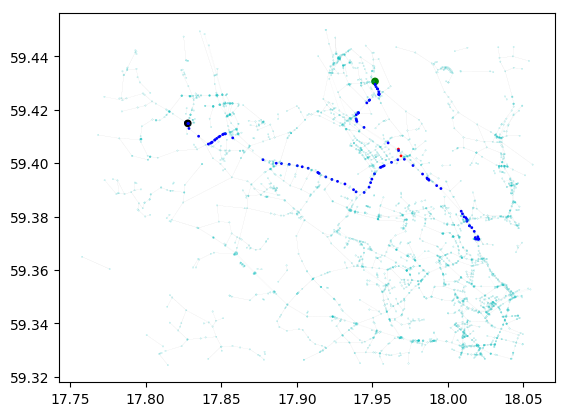

In [107]:
nn_path_nodes = [1082, 757, 3155, 3454, 176, 672, 1561, 766, 2887, 2834, 600, 2683, 854, 771, 104, 3116, 2945, 2533, 1997, 2676, 2279, 2451, 2146, 1238, 529, 897, 3266, 1439, 2639, 1719, 155, 169, 2699, 2096, 1292, 273, 2728, 2897, 759, 2635, 1154, 1970, 2006, 3378, 2851, 1391, 973, 590, 17, 862, 1488, 2103, 1397, 2391, 762, 300, 895, 833, 2833, 1395, 2841, 2382, 3022, 64, 375, 3408, 385, 9, 1592, 3199, 3194, 444, 1060, 2405, 2160, 1837, 2938, 1680, 2829, 1981, 532, 2708, 398, 1977, 1353, 3288, 1745, 579, 2172, 238, 2084, 1934, 373, 1957, 1546, 2487, 1533, 559, 3171, 1605, 213, 2641]
gt_path_nodes = [1082, 757, 3155, 3454, 176, 672, 1561, 766, 2887, 2834, 600, 2683, 854, 771, 104, 3116, 2945, 2533, 1997, 2676, 2279, 2451, 2146, 1238, 529, 897, 3266, 1439, 2639, 1719, 155, 169, 2699, 2096, 1292, 273, 2728, 2897, 759, 2635, 1154, 1970, 2006, 3378, 2851, 1391, 973, 395, 456, 2938, 1680, 2829, 1981, 532, 2708, 398, 1977, 1353, 3288, 1745, 579, 2172, 238, 2084, 1934, 373, 1957, 1546, 2487, 1533, 559, 3171, 1605, 213, 2641]
plot_gt_nn_comparison(graph, gt_path_nodes, nn_path_nodes)

### Building Simulation Environment

In [9]:
type Model
    name::String
    active::Bool
    src::Int
    dst::Int
    edge_src::Int
    edge_dst::Int
    start_t::Float64
    end_t::Float64
    elapsed_t::Float64
    left_t::Float64
end

In [112]:
function calc_temp_edge_weight(edge, traffic)
    
    segmentlen = edgeDict[Edge(edge[1], edge[2])][:segmentlen]
    speed = edgeDict[Edge(edge[1], edge[2])][:speed]
    
    weight = segmentlen / speed
    factor = 1 - e ^ (-0.08traffic)
    weight *= (1 + factor)
    
    return weight
end

function dummy_infer_next_node(G, parent, cur_node, Q)
    candidates = filter(node -> node != parent, outneighbors(G, cur_node))
    
    if length(candidates) == 0
        return (0.0, parent)
    end
    
    candidates = map(node -> (calc_temp_edge_weight((cur_node, node), Q[(cur_node, node)]),
                                node), candidates)
    return minimum(candidates)
end

function init_simulation(G, N)
    
    Q = Dict()
    M = Dict()
    
    for k in keys(edge_weights)
        Q[k] = 0
    end
    
    selected_edges = [sample(collect(keys(edge_weights))) for _ in 1:N]
    models = Array{Model, 1}(N)
    
    for edge in selected_edges
        Q[edge] += 1
    end
    
    edge_model_countor = Dict()
    
    for (idx, edge) in enumerate(selected_edges)
        
        edge_traffic = 0
        if haskey(edge_model_countor, edge)
            edge_traffic = edge_model_countor[edge]
            edge_model_countor[edge] += 1
        else
            edge_model_countor[edge] = 1
        end
        
        end_t = calc_temp_edge_weight(edge, edge_traffic)
        
        models[idx] = Model("model_$(idx)", true, 0, 0, edge[1], edge[2], 0.0, end_t, 0.0, end_t)
    end
    
    for model in models
        M[model.name] = []
    end
    
    return Q, M, models
end

import Base.isless

function isless(m1::Model, m2::Model)
    return m1.left_t <= m2.left_t
end

function pick_model_least_left_t(models)
   return minimum(filter(m -> m.active, models))
end

function update_all_other_models_in_M!(models, model_least)
    
    # Parallelize this part
    for model in models

        (!model.active || model.name == model_least.name) && continue

        model.elapsed_t += model_least.left_t
        model.left_t -= model_least.left_t
    end
end

function record_model_least_in_M!(M, model_least)
    
    push!(M[model_least.name], 
            (model_least.edge_src, 
            model_least.edge_dst, 
            model_least.start_t, 
            model_least.end_t,
            model_least.elapsed_t, 
            model_least.left_t))
end

record_model_least_in_M! (generic function with 1 method)

In [154]:
function print_models(models)
    
    for m in models
        println(m)
    end 
end

function simulation(G; N=10, Z=Int(ceil(num_nodes * 0.2)))
    
    Q, M, models = init_simulation(graph, N)
    
    num_active_models = N
    
    while num_active_models > 0
        
        model_least = pick_model_least_left_t(models)
        println("Selected model: $(model_least)")
        println("Current model state")
        print_models(models)
        println()
        # The model has traverse enough edges
        if length(M[model_least.name]) >= Z
            num_active_models -= 1
            Q[(model_least.edge_src, model_least.edge_dst)] -= 1
            
            record_model_least_in_M!(M, model_least)
            
            # update all other models' time
            update_all_other_models_in_M!(models, model_least)
            model_least.active = false
            model_least.elapsed_t = 0.0
            model_least.left_t = 0.0
            
            println("Leaving first continue")
            println("Model: $(model_least)")
            println()
            continue
        end
        
        next_weight, next_node = dummy_infer_next_node(G, 
                                        model_least.edge_src, 
                                        model_least.edge_dst,
                                        Q)
        
        # The model got into a deadend
        if next_node == model_least.edge_src
            num_active_models -= 1
            model_least.active = false
            Q[(model_least.edge_src, model_least.edge_dst)] -= 1
            
            record_model_least_in_M!(M, model_least)
            
            # update all other models' time
            update_all_other_models_in_M!(models, model_least)
            model_least.active = false
            model_least.elapsed_t = 0.0
            model_least.left_t = 0.0
            
            println("Leaving second continue")
            println("Model: $(model_least)")
            println()
            continue
        end
        
        @assert next_weight > 0 
        
        record_model_least_in_M!(M, model_least)
        update_all_other_models_in_M!(models, model_least)
        
        Q[(model_least.edge_src, model_least.edge_dst)] -= 1
        model_least.edge_src = model_least.edge_dst
        model_least.edge_dst = next_node
        Q[(model_least.edge_src, model_least.edge_dst)] += 1
        model_least.elapsed_t = 0.0
        model_least.left_t = next_weight
        model_least.start_t = model_least.end_t
        model_least.end_t += next_weight
        
        
        
#         println("Leaving End of the loop")
    end
    
    return M, models
end

simulation (generic function with 1 method)

In [184]:
M, models = simulation(graph, Z=100);

Selected model: Model("model_9", true, 0, 0, 162, 28, 0.0, 0.7531269121315942, 0.0, 0.7531269121315942)
Current model state
Model("model_1", true, 0, 0, 129, 158, 0.0, 3.2560279361700584, 0.0, 3.2560279361700584)
Model("model_2", true, 0, 0, 94, 67, 0.0, 5.975208448770323, 0.0, 5.975208448770323)
Model("model_3", true, 0, 0, 94, 189, 0.0, 12.303345594641277, 0.0, 12.303345594641277)
Model("model_4", true, 0, 0, 16, 104, 0.0, 3.346304962581378, 0.0, 3.346304962581378)
Model("model_5", true, 0, 0, 133, 210, 0.0, 15.248952158789368, 0.0, 15.248952158789368)
Model("model_6", true, 0, 0, 161, 133, 0.0, 16.17722751314503, 0.0, 16.17722751314503)
Model("model_7", true, 0, 0, 51, 7, 0.0, 7.0503985634530135, 0.0, 7.0503985634530135)
Model("model_8", true, 0, 0, 207, 65, 0.0, 20.344224663719366, 0.0, 20.344224663719366)
Model("model_9", true, 0, 0, 162, 28, 0.0, 0.7531269121315942, 0.0, 0.7531269121315942)
Model("model_10", true, 0, 0, 164, 36, 0.0, 11.037816231163028, 0.0, 11.037816231163028)



Model("model_10", true, 0, 0, 164, 36, 0.0, 11.037816231163028, 7.0503985634530135, 3.987417667710014)

Selected model: Model("model_2", true, 0, 0, 67, 14, 5.975208448770323, 10.454131142938053, 2.19135416085644, 2.2875685333112883)
Current model state
Model("model_1", true, 0, 0, 158, 192, 3.2560279361700584, 10.875052946358544, 4.910534673456706, 2.70849033673178)
Model("model_2", true, 0, 0, 67, 14, 5.975208448770323, 10.454131142938053, 2.19135416085644, 2.2875685333112883)
Model("model_3", true, 0, 0, 94, 189, 0.0, 12.303345594641277, 8.166562609626764, 4.136782985014515)
Model("model_4", true, 0, 0, 99, 36, 6.719514539664685, 20.943825802515324, 1.4470480699620791, 12.77726319288856)
Model("model_5", true, 0, 0, 133, 210, 0.0, 15.248952158789368, 8.166562609626764, 7.082389549162604)
Model("model_6", true, 0, 0, 161, 133, 0.0, 16.17722751314503, 8.166562609626764, 8.010664903518267)
Model("model_7", true, 0, 0, 7, 149, 7.0503985634530135, 12.174249861593495, 1.11616404617375, 4.

Model("model_7", true, 0, 0, 149, 82, 12.174249861593495, 20.600814339975756, 3.074702297195873, 5.351862181186387)
Model("model_8", true, 0, 0, 207, 65, 0.0, 20.344224663719366, 15.248952158789368, 5.095272504929998)
Model("model_9", true, 0, 0, 51, 7, 14.247123735974894, 21.297522299427907, 1.0018284228144743, 6.048570140638539)
Model("model_10", true, 0, 0, 126, 14, 11.356151898428141, 22.52012455030085, 3.8928002603612257, 7.2711723915114845)

Selected model: Model("model_5", true, 0, 0, 210, 95, 15.248952158789368, 16.370402729474606, 0.9282753543556619, 0.1931752163295768)
Current model state
Model("model_1", false, 0, 0, 158, 192, 3.2560279361700584, 10.875052946358544, 0.0, 0.0)
Model("model_2", true, 0, 0, 14, 126, 10.454131142938053, 21.618103794810764, 5.723096370206978, 5.44087628166573)
Model("model_3", true, 0, 0, 189, 126, 12.303345594641277, 26.29411865215547, 3.873881918503751, 10.11689113901044)
Model("model_4", true, 0, 0, 99, 36, 6.719514539664685, 20.94382580251532

Model("model_10", true, 0, 0, 126, 14, 11.356151898428141, 22.52012455030085, 9.58767390408718, 1.5762987477855288)

Selected model: Model("model_9", true, 0, 0, 51, 7, 14.247123735974894, 21.297522299427907, 7.015037733805544, 0.03536082964746895)
Current model state
Model("model_1", false, 0, 0, 158, 192, 3.2560279361700584, 10.875052946358544, 0.0, 0.0)
Model("model_2", true, 0, 0, 14, 126, 10.454131142938053, 21.618103794810764, 10.808030326842385, 0.3559423250303226)
Model("model_3", true, 0, 0, 189, 126, 12.303345594641277, 26.29411865215547, 8.958815875139159, 5.031957182375032)
Model("model_4", true, 0, 0, 126, 14, 21.262161469780438, 33.284461127968804, 0.0, 12.022299658188365)
Model("model_5", true, 0, 0, 111, 142, 20.36713474742037, 23.25460523564081, 0.8950267223600672, 1.9924437658603726)
Model("model_6", true, 0, 0, 176, 170, 17.065260455454244, 33.21584940149569, 4.196901014326197, 11.953687931715253)
Model("model_7", true, 0, 0, 82, 47, 20.600814339975756, 35.2777918406

Model("model_6", true, 0, 0, 176, 170, 17.065260455454244, 33.21584940149569, 6.442245459623521, 9.708343486417926)
Model("model_7", true, 0, 0, 82, 47, 20.600814339975756, 35.2777918406221, 2.9066915751020077, 11.770285925544338)
Model("model_8", true, 0, 0, 77, 65, 23.507505915077765, 24.403647932087026, 0.0, 0.8961420170092601)
Model("model_9", true, 0, 0, 7, 149, 21.297522299427907, 26.42137359756839, 2.2099836156498567, 2.913867682490625)
Model("model_10", true, 0, 0, 14, 67, 22.52012455030085, 26.999047244468578, 0.9873813647769107, 3.491541329390818)

Selected model: Model("model_5", true, 0, 0, 142, 89, 23.25460523564081, 24.713311206487628, 1.1490426964462128, 0.3096632744006046)
Current model state
Model("model_1", false, 0, 0, 158, 192, 3.2560279361700584, 10.875052946358544, 0.0, 0.0)
Model("model_2", true, 0, 0, 36, 164, 21.936439462075878, 32.9742556932389, 2.467208470011149, 8.570607761151877)
Model("model_3", true, 0, 0, 189, 126, 12.303345594641277, 26.29411865215547, 

Model("model_2", true, 0, 0, 36, 164, 21.936439462075878, 32.9742556932389, 5.062607782392707, 5.975208448770319)
Model("model_3", true, 0, 0, 36, 164, 26.612454319420582, 38.49889819034832, 0.3865929250479981, 11.49985094587974)
Model("model_4", true, 0, 0, 126, 14, 21.262161469780438, 33.284461127968804, 5.736885774688144, 6.285413883500219)
Model("model_5", true, 0, 0, 186, 211, 26.463741987115732, 27.863619253140392, 0.5353052573528491, 0.8645720086718118)
Model("model_6", true, 0, 0, 176, 170, 17.065260455454244, 33.21584940149569, 9.933786789014341, 6.216802157027107)
Model("model_7", true, 0, 0, 82, 47, 20.600814339975756, 35.2777918406221, 6.398232904492826, 8.278744596153516)
Model("model_8", true, 0, 0, 22, 77, 26.440354306656467, 27.566929183445424, 0.5586929378121176, 0.5678819389768393)
Model("model_9", true, 0, 0, 149, 82, 26.42137359756839, 34.84793807595065, 0.577673646900193, 7.848890831482065)
Model("model_10", true, 0, 0, 67, 94, 26.999047244468578, 32.9742556932389,

Model("model_10", true, 0, 0, 67, 94, 26.999047244468578, 32.9742556932389, 5.523447224353757, 0.45176122441656685)

Selected model: Model("model_2", true, 0, 0, 36, 164, 21.936439462075878, 32.9742556932389, 10.71988526277001, 0.31793096839301804)
Current model state
Model("model_1", false, 0, 0, 158, 192, 3.2560279361700584, 10.875052946358544, 0.0, 0.0)
Model("model_2", true, 0, 0, 36, 164, 21.936439462075878, 32.9742556932389, 10.71988526277001, 0.31793096839301804)
Model("model_3", true, 0, 0, 36, 164, 26.612454319420582, 38.49889819034832, 6.043870405425299, 5.842573465502438)
Model("model_4", true, 0, 0, 126, 14, 21.262161469780438, 33.284461127968804, 11.394163255065449, 0.628136403122918)
Model("model_5", true, 0, 0, 95, 141, 32.65632472484588, 35.2784359774302, 0.0, 2.622111252584319)
Model("model_6", true, 0, 0, 176, 170, 17.065260455454244, 33.21584940149569, 15.591064269391646, 0.5595246766498063)
Model("model_7", true, 0, 0, 82, 47, 20.600814339975756, 35.2777918406221, 1

Model("model_6", true, 0, 0, 161, 75, 34.1805854114863, 40.27061171100487, 0.6673526644643472, 5.422673635054222)
Model("model_7", true, 0, 0, 82, 47, 20.600814339975756, 35.2777918406221, 14.247123735974895, 0.4298537646714503)
Model("model_8", true, 0, 0, 22, 77, 34.559200843391785, 35.68577572018074, 0.28873723255886896, 0.8378376442300878)
Model("model_9", true, 0, 0, 82, 187, 34.84793807595065, 49.765808696933405, 0.0, 14.91787062098275)
Model("model_10", true, 0, 0, 94, 162, 32.9742556932389, 38.96898730889587, 1.8736823827117428, 4.121049232945224)

Selected model: Model("model_5", true, 0, 0, 95, 141, 32.65632472484588, 35.2784359774302, 2.6214671157762153, 0.0006441368081038235)
Current model state
Model("model_1", false, 0, 0, 158, 192, 3.2560279361700584, 10.875052946358544, 0.0, 0.0)
Model("model_2", true, 0, 0, 164, 138, 32.9742556932389, 40.2148274697523, 2.3035361473831975, 4.937035629130201)
Model("model_3", true, 0, 0, 36, 164, 26.612454319420582, 38.49889819034832, 8.

Model("model_10", true, 0, 0, 94, 162, 32.9742556932389, 38.96898730889587, 4.822156993280952, 1.1725746223760147)

Selected model: Model("model_8", true, 0, 0, 33, 22, 37.71558917552285, 38.618624111759445, 0.7833090148254778, 0.1197259214111156)
Current model state
Model("model_1", false, 0, 0, 158, 192, 3.2560279361700584, 10.875052946358544, 0.0, 0.0)
Model("model_2", true, 0, 0, 164, 138, 32.9742556932389, 40.2148274697523, 5.5246424971094195, 1.715929279403979)
Model("model_3", true, 0, 0, 164, 138, 38.49889819034832, 46.29615157928988, 0.0, 7.797253388941558)
Model("model_4", true, 0, 0, 67, 94, 37.76338382213653, 43.73859227090686, 0.7355143682117911, 5.239694080558532)
Model("model_5", true, 0, 0, 111, 142, 36.65305674279164, 39.54052723101208, 1.845841447556674, 1.041629040663766)
Model("model_6", true, 0, 0, 161, 75, 34.1805854114863, 40.27061171100487, 4.31831277886202, 1.77171352065655)
Model("model_7", true, 0, 0, 138, 164, 37.79641268651986, 45.03698446303326, 0.70248550

Model("model_5", true, 0, 0, 142, 89, 39.54052723101208, 40.99923320185889, 1.0793606007464027, 0.379345370100415)
Model("model_6", true, 0, 0, 75, 19, 40.27061171100487, 47.22381546997812, 0.3492761207536187, 6.603927638219634)
Model("model_7", true, 0, 0, 138, 164, 37.79641268651986, 45.03698446303326, 2.8234751452386315, 4.417096631274768)
Model("model_8", true, 0, 0, 77, 65, 39.7451989885484, 40.64134100555766, 0.8746888432100963, 0.021453173799163783)
Model("model_9", true, 0, 0, 82, 187, 34.84793807595065, 49.765808696933405, 5.771949755807841, 9.145920865174908)
Model("model_10", true, 0, 0, 4, 201, 40.61988783175848, 47.13554991852263, 0.0, 6.515662086764148)

Selected model: Model("model_5", true, 0, 0, 142, 89, 39.54052723101208, 40.99923320185889, 1.1008137745455664, 0.35789219630125124)
Current model state
Model("model_1", false, 0, 0, 158, 192, 3.2560279361700584, 10.875052946358544, 0.0, 0.0)
Model("model_2", true, 0, 0, 138, 47, 40.2148274697523, 42.73344831565006, 0.426

Model("model_2", true, 0, 0, 47, 82, 42.73344831565006, 57.4104258162964, 1.4160929328616103, 13.260884567784736)
Model("model_3", true, 0, 0, 164, 138, 38.49889819034832, 46.29615157928988, 5.65064305816335, 2.146610330778209)
Model("model_4", true, 0, 0, 94, 162, 43.73859227090686, 49.733323886563824, 0.41094897760481697, 5.583782638052151)
Model("model_5", true, 0, 0, 211, 210, 44.14954124851166, 47.82079614953191, 0.0, 3.6712549010202506)
Model("model_6", true, 0, 0, 75, 19, 40.27061171100487, 47.22381546997812, 3.8789295375067985, 3.074274221466454)
Model("model_7", true, 0, 0, 138, 164, 37.79641268651986, 45.03698446303326, 6.353128561991813, 0.887443214521588)
Model("model_8", true, 0, 0, 77, 65, 43.80462225691606, 44.70076427392532, 0.34491899159561923, 0.5512230254136409)
Model("model_9", true, 0, 0, 82, 187, 34.84793807595065, 49.765808696933405, 9.301603172561022, 5.616267448421727)
Model("model_10", true, 0, 0, 4, 201, 40.61988783175848, 47.13554991852263, 3.52965341675318,

Model("model_3", true, 0, 0, 138, 47, 46.29615157928988, 48.814772425187634, 1.5246445702420415, 0.9939762756557183)
Model("model_4", true, 0, 0, 94, 162, 43.73859227090686, 49.733323886563824, 4.082203878625068, 1.9125277370318998)
Model("model_5", true, 0, 0, 210, 95, 47.82079614953191, 48.94224672021715, 0.0, 1.1214505706852387)
Model("model_6", true, 0, 0, 19, 7, 47.22381546997812, 53.07250521927095, 0.5969806795537965, 5.2517090697390305)
Model("model_7", true, 0, 0, 164, 36, 45.03698446303326, 56.074800694196284, 2.783811686498663, 8.254004544664365)
Model("model_8", true, 0, 0, 22, 77, 46.737470648494764, 47.86404552528372, 1.0833255010371694, 0.04324937575178733)
Model("model_9", true, 0, 0, 82, 187, 34.84793807595065, 49.765808696933405, 12.972858073581275, 1.9450125474014759)
Model("model_10", true, 0, 0, 201, 51, 47.13554991852263, 53.21611104487076, 0.6852462310092821, 5.3953148953388474)

Selected model: Model("model_8", true, 0, 0, 77, 65, 47.86404552528372, 48.7601875422

Model("model_10", true, 0, 0, 201, 51, 47.13554991852263, 53.21611104487076, 3.030172024279277, 3.0503891020688516)

Selected model: Model("model_8", true, 0, 0, 33, 22, 49.89385898062583, 50.79689391686242, 0.5925918180695994, 0.31044311816699405)
Current model state
Model("model_1", false, 0, 0, 158, 192, 3.2560279361700584, 10.875052946358544, 0.0, 0.0)
Model("model_2", true, 0, 0, 47, 82, 42.73344831565006, 57.4104258162964, 7.753002483045355, 6.923975017600988)
Model("model_3", true, 0, 0, 47, 82, 48.814772425187634, 64.62016958008482, 1.6716783735077758, 14.133718781389407)
Model("model_4", true, 0, 0, 28, 4, 50.486450798695415, 51.38422440942644, 0.0, 0.8977736107310225)
Model("model_5", true, 0, 0, 95, 141, 48.94224672021715, 51.56435797280147, 1.5442040784782554, 1.0779071741060635)
Model("model_6", true, 0, 0, 19, 7, 47.22381546997812, 53.07250521927095, 3.2626353287172902, 2.586054420575536)
Model("model_7", true, 0, 0, 164, 36, 45.03698446303326, 56.074800694196284, 5.44946

Model("model_5", true, 0, 0, 141, 111, 51.56435797280147, 52.93897873816291, 1.2552528378591474, 0.1193679275022973)
Model("model_6", true, 0, 0, 19, 7, 47.22381546997812, 53.07250521927095, 5.595795340682501, 0.25289440861032497)
Model("model_7", true, 0, 0, 164, 36, 45.03698446303326, 56.074800694196284, 7.782626347627367, 3.2551898835356603)
Model("model_8", true, 0, 0, 65, 33, 52.81961081066064, 53.95328224899349, 0.0, 1.1336714383328472)
Model("model_9", true, 0, 0, 115, 29, 51.785670386656875, 71.59358585869593, 1.0339404240037577, 18.773975048035293)
Model("model_10", true, 0, 0, 201, 51, 47.13554991852263, 53.21611104487076, 5.684060892137986, 0.39650023421014213)

Selected model: Model("model_6", true, 0, 0, 19, 7, 47.22381546997812, 53.07250521927095, 5.715163268184798, 0.13352648110802767)
Current model state
Model("model_1", false, 0, 0, 158, 192, 3.2560279361700584, 10.875052946358544, 0.0, 0.0)
Model("model_2", true, 0, 0, 47, 82, 42.73344831565006, 57.4104258162964, 10.2

Model("model_8", true, 0, 0, 77, 65, 55.98289206201904, 56.8790340790283, 0.41024429944237767, 0.48589771756688244)
Model("model_9", true, 0, 0, 115, 29, 51.785670386656875, 71.59358585869593, 4.6074659748045335, 15.20044949723452)
Model("model_10", true, 0, 0, 51, 7, 53.21611104487076, 60.26650960832377, 3.177025316590633, 3.8733732468623816)

Selected model: Model("model_5", true, 0, 0, 142, 89, 55.826449226383346, 57.28515519723016, 1.0525848526449195, 0.40612111820189817)
Current model state
Model("model_1", false, 0, 0, 158, 192, 3.2560279361700584, 10.875052946358544, 0.0, 0.0)
Model("model_2", true, 0, 0, 47, 82, 42.73344831565006, 57.4104258162964, 14.145585763378222, 0.5313917372681196)
Model("model_3", true, 0, 0, 47, 82, 48.814772425187634, 64.62016958008482, 8.064261653840646, 7.741135501056539)
Model("model_4", true, 0, 0, 4, 201, 51.38422440942644, 57.89988649619058, 5.494809669601847, 1.0208524171623017)
Model("model_5", true, 0, 0, 142, 89, 55.826449226383346, 57.285155

Model("model_4", true, 0, 0, 201, 51, 57.89988649619058, 63.98044762253871, 2.1424288341960955, 3.938132292152035)
Model("model_5", true, 0, 0, 186, 211, 59.03558597785827, 60.43546324388293, 1.0067293525283945, 0.3931479134962663)
Model("model_6", true, 0, 0, 149, 82, 58.19635651741143, 66.62292099579369, 1.8459588129752476, 6.580605665407013)
Model("model_7", true, 0, 0, 126, 14, 56.3931363614614, 67.55710901333411, 3.6491789689252796, 7.514793682947431)
Model("model_8", true, 0, 0, 77, 65, 60.0423153303867, 60.93845734739596, 0.0, 0.8961420170092601)
Model("model_9", true, 0, 0, 115, 29, 51.785670386656875, 71.59358585869593, 8.256644943729812, 11.55127052830924)
Model("model_10", true, 0, 0, 51, 7, 53.21611104487076, 60.26650960832377, 6.826204285515912, 0.22419427793710156)

Selected model: Model("model_5", true, 0, 0, 186, 211, 59.03558597785827, 60.43546324388293, 1.230923630465496, 0.16895363555916476)
Current model state
Model("model_1", false, 0, 0, 158, 192, 3.25602793617005

Model("model_4", true, 0, 0, 51, 7, 63.98044762253871, 71.03084618599172, 0.6397219575461088, 6.410676605906905)
Model("model_5", true, 0, 0, 210, 95, 64.10671814490318, 65.22816871558842, 0.5134514351816266, 0.6079991355036121)
Model("model_6", true, 0, 0, 149, 82, 58.19635651741143, 66.62292099579369, 6.42381306267339, 2.00275141570887)
Model("model_7", true, 0, 0, 126, 14, 56.3931363614614, 67.55710901333411, 8.227033218623422, 2.936939433249288)
Model("model_8", true, 0, 0, 77, 65, 64.10173859875435, 64.9978806157636, 0.5184309813304862, 0.37771103567877395)
Model("model_9", true, 0, 0, 115, 29, 51.785670386656875, 71.59358585869593, 12.834499193427956, 6.973416278611098)
Model("model_10", true, 0, 0, 7, 149, 60.26650960832377, 65.39036090646425, 4.353659971761042, 0.7701913263794395)

Selected model: Model("model_5", true, 0, 0, 210, 95, 64.10671814490318, 65.22816871558842, 0.8911624708604006, 0.2302880998248381)
Current model state
Model("model_1", false, 0, 0, 158, 192, 3.25602

Model("model_9", true, 0, 0, 115, 29, 51.785670386656875, 71.59358585869593, 16.064609581515885, 3.7433058905231666)
Model("model_10", true, 0, 0, 149, 82, 65.39036090646425, 74.46479044935313, 2.459919061708492, 6.614510481180392)

Selected model: Model("model_8", true, 0, 0, 77, 65, 68.161161867122, 69.05730388413126, 0.0, 0.8961420170092601)
Current model state
Model("model_1", false, 0, 0, 158, 192, 3.2560279361700584, 10.875052946358544, 0.0, 0.0)
Model("model_2", true, 0, 0, 149, 7, 65.83699029467866, 70.96084159281914, 2.324171572443331, 2.7996797256971506)
Model("model_3", true, 0, 0, 82, 149, 64.62016958008482, 73.6945991229737, 3.5409922870371715, 5.533437255851711)
Model("model_4", true, 0, 0, 51, 7, 63.98044762253871, 71.03084618599172, 4.18071424458328, 2.8696843188697336)
Model("model_5", true, 0, 0, 141, 111, 67.85027996817274, 69.22490073353418, 0.3108818989492401, 1.0637388664122045)
Model("model_6", true, 0, 0, 82, 47, 66.62292099579369, 81.29989849644004, 1.538240871

Model("model_7", true, 0, 0, 67, 94, 72.03603170750185, 78.01124015627217, 0.07633951425279895, 5.898868934517525)
Model("model_8", true, 0, 0, 22, 77, 71.0940102587007, 72.22058513548966, 1.0183609630539439, 0.10821391373501288)
Model("model_9", true, 0, 0, 29, 63, 71.59358585869593, 74.80546720615014, 0.5187853630587181, 2.6930959843954976)
Model("model_10", true, 0, 0, 149, 82, 65.39036090646425, 74.46479044935313, 6.722010315290378, 2.3524192275985083)

Selected model: Model("model_8", true, 0, 0, 77, 65, 72.22058513548966, 73.11672715249891, 0.0, 0.8961420170092601)
Current model state
Model("model_1", false, 0, 0, 158, 192, 3.2560279361700584, 10.875052946358544, 0.0, 0.0)
Model("model_2", true, 0, 0, 7, 19, 70.96084159281914, 76.80953134211197, 1.2597435426705068, 4.58894620662232)
Model("model_3", true, 0, 0, 82, 149, 64.62016958008482, 73.6945991229737, 7.6004155554048305, 1.474013987484054)
Model("model_4", true, 0, 0, 7, 149, 71.03084618599172, 76.1546974841322, 1.1897389494

Model("model_10", true, 0, 0, 82, 187, 74.46479044935313, 89.38266107033589, 0.6886430777152054, 14.229227543267545)

Selected model: Model("model_4", true, 0, 0, 7, 149, 71.03084618599172, 76.1546974841322, 4.290661787237833, 0.8331895109026478)
Current model state
Model("model_1", false, 0, 0, 158, 192, 3.2560279361700584, 10.875052946358544, 0.0, 0.0)
Model("model_2", true, 0, 0, 7, 19, 70.96084159281914, 76.80953134211197, 4.360666380410416, 1.488023368882411)
Model("model_3", true, 0, 0, 149, 7, 73.6945991229737, 78.81845042111418, 1.6269088502558549, 3.496942447884626)
Model("model_4", true, 0, 0, 7, 149, 71.03084618599172, 76.1546974841322, 4.290661787237833, 0.8331895109026478)
Model("model_5", true, 0, 0, 186, 211, 75.32150797322956, 76.72138523925422, 0.0, 1.3998772660246608)
Model("model_6", true, 0, 0, 82, 47, 66.62292099579369, 81.29989849644004, 8.698586977435868, 5.97839052321048)
Model("model_7", true, 0, 0, 67, 94, 72.03603170750185, 78.01124015627217, 3.28547626572772

Model("model_6", true, 0, 0, 82, 47, 66.62292099579369, 81.29989849644004, 12.589935799642317, 2.0870417010040314)
Model("model_7", true, 0, 0, 94, 162, 78.01124015627217, 84.00597177192914, 1.2016166391638463, 4.793114976493121)
Model("model_8", true, 0, 0, 22, 77, 79.21285679543601, 80.33943167222496, 0.0, 1.1265748767889567)
Model("model_9", true, 0, 0, 63, 35, 74.80546720615014, 82.63215415932599, 4.407389589285874, 3.419297363889981)
Model("model_10", true, 0, 0, 82, 187, 74.46479044935313, 89.38266107033589, 4.748066346082863, 10.169804274899887)

Selected model: Model("model_5", true, 0, 0, 211, 210, 76.72138523925422, 80.39264014027447, 3.6180464329707447, 0.053208468049505964)
Current model state
Model("model_1", false, 0, 0, 158, 192, 3.2560279361700584, 10.875052946358544, 0.0, 0.0)
Model("model_2", true, 0, 0, 19, 76, 76.80953134211197, 83.68074764657798, 3.5299003301129948, 3.3413159743530167)
Model("model_3", true, 0, 0, 7, 19, 78.81845042111418, 84.66714017040701, 1.5209

Selected model: Model("model_7", true, 0, 0, 94, 162, 78.01124015627217, 84.00597177192914, 5.807279186065637, 0.18745242959133002)
Current model state
Model("model_1", false, 0, 0, 158, 192, 3.2560279361700584, 10.875052946358544, 0.0, 0.0)
Model("model_2", true, 0, 0, 76, 28, 83.68074764657798, 89.9348372972627, 0.13777169575981763, 6.1163179549249085)
Model("model_3", true, 0, 0, 7, 19, 78.81845042111418, 84.66714017040701, 5.000068921223614, 0.8486208280692128)
Model("model_4", true, 0, 0, 149, 82, 76.1546974841322, 84.58126196251446, 7.663821858205592, 0.7627426201766677)
Model("model_5", true, 0, 0, 95, 141, 81.5140907109597, 84.13620196354402, 2.30442863137809, 0.31768262120622914)
Model("model_6", true, 0, 0, 138, 164, 83.8185193423378, 91.0590911188512, 0.0, 7.2405717765133994)
Model("model_7", true, 0, 0, 94, 162, 78.01124015627217, 84.00597177192914, 5.807279186065637, 0.18745242959133002)
Model("model_8", true, 0, 0, 22, 77, 83.27228006380366, 84.39885494059261, 0.546239278

Model("model_7", true, 0, 0, 28, 4, 84.75909868406073, 85.65687229479175, 0.7517240448447496, 0.14604956588627283)
Model("model_8", true, 0, 0, 65, 33, 85.29499695760187, 86.42866839593472, 0.21582577130359082, 0.9178456670292564)
Model("model_9", true, 0, 0, 112, 145, 84.86895699147063, 102.33463326348152, 0.6418657374348539, 16.823810534576033)
Model("model_10", true, 0, 0, 82, 187, 74.46479044935313, 89.38266107033589, 11.046032279552326, 3.8718383414304216)

Selected model: Model("model_8", true, 0, 0, 65, 33, 85.29499695760187, 86.42866839593472, 0.36187533718986364, 0.7717961011429836)
Current model state
Model("model_1", false, 0, 0, 158, 192, 3.2560279361700584, 10.875052946358544, 0.0, 0.0)
Model("model_2", true, 0, 0, 76, 28, 83.68074764657798, 89.9348372972627, 1.9761246482137642, 4.277965002470962)
Model("model_3", true, 0, 0, 19, 76, 84.66714017040701, 91.53835647487303, 0.9897321243847339, 5.881484180081278)
Model("model_4", true, 0, 0, 82, 47, 84.58126196251446, 99.25823

Model("model_1", false, 0, 0, 158, 192, 3.2560279361700584, 10.875052946358544, 0.0, 0.0)
Model("model_2", true, 0, 0, 76, 28, 83.68074764657798, 89.9348372972627, 6.176251541394749, 0.07783810928997759)
Model("model_3", true, 0, 0, 19, 76, 84.66714017040701, 91.53835647487303, 5.189859017565719, 1.6813572869002937)
Model("model_4", true, 0, 0, 82, 47, 84.58126196251446, 99.2582394631608, 5.275737225458264, 9.40124027518808)
Model("model_5", true, 0, 0, 89, 186, 89.85699918797273, 91.60742996860084, 0.0, 1.7504307806281045)
Model("model_6", true, 0, 0, 138, 164, 83.8185193423378, 91.0590911188512, 6.038479845634931, 1.202091930878468)
Model("model_7", true, 0, 0, 4, 201, 85.65687229479175, 92.1725343815559, 4.200126893180984, 2.315535193583163)
Model("model_8", true, 0, 0, 65, 33, 89.35442022596952, 90.48809166430237, 0.5025789620031907, 0.6310924763296566)
Model("model_9", true, 0, 0, 112, 145, 84.86895699147063, 102.33463326348152, 4.988042196502112, 12.477634075508774)
Model("model_

Model("model_8", true, 0, 0, 22, 77, 91.39112660053897, 92.51770147732792, 0.14722987433404378, 0.9793450024549131)
Model("model_9", true, 0, 0, 112, 145, 84.86895699147063, 102.33463326348152, 6.669399483402406, 10.796276788608479)
Model("model_10", true, 0, 0, 115, 29, 91.40252276005937, 111.21043823209843, 0.13583371481365836, 19.672081757225396)

Selected model: Model("model_7", true, 0, 0, 4, 201, 85.65687229479175, 92.1725343815559, 5.950557673809091, 0.5651044129550588)
Current model state
Model("model_1", false, 0, 0, 158, 192, 3.2560279361700584, 10.875052946358544, 0.0, 0.0)
Model("model_2", true, 0, 0, 162, 94, 90.6879642093943, 96.68269582505127, 0.9194657592065326, 5.075265856450433)
Model("model_3", true, 0, 0, 76, 28, 91.53835647487303, 97.79244612555775, 0.0690734937278108, 6.185016156956915)
Model("model_4", true, 0, 0, 82, 47, 84.58126196251446, 99.2582394631608, 7.02616800608637, 7.650809494559973)
Model("model_5", true, 0, 0, 186, 211, 91.60742996860084, 93.00730723

Model("model_1", false, 0, 0, 158, 192, 3.2560279361700584, 10.875052946358544, 0.0, 0.0)
Model("model_2", true, 0, 0, 94, 67, 96.68269582505127, 102.65790427382159, 0.0, 5.975208448770323)
Model("model_3", true, 0, 0, 76, 28, 91.53835647487303, 97.79244612555775, 5.144339350178244, 1.109750300506481)
Model("model_4", true, 0, 0, 82, 47, 84.58126196251446, 99.2582394631608, 12.101433862536805, 2.575543638109539)
Model("model_5", true, 0, 0, 210, 95, 96.67856213564575, 97.80001270633099, 0.004133689405522389, 1.1173168812797163)
Model("model_6", true, 0, 0, 164, 36, 91.0590911188512, 102.09690735001422, 5.623604706200069, 5.414211524962958)
Model("model_7", true, 0, 0, 201, 51, 92.1725343815559, 98.25309550790404, 4.510161443495374, 1.5703996828527549)
Model("model_8", true, 0, 0, 77, 65, 96.57712474569557, 97.47326676270482, 0.10557107935567389, 0.7905709376535862)
Model("model_9", true, 0, 0, 112, 145, 84.86895699147063, 102.33463326348152, 11.81373883358065, 5.651937438430236)
Model(

Model("model_6", true, 0, 0, 164, 36, 91.0590911188512, 102.09690735001422, 9.363032840064106, 1.674783391098923)
Model("model_7", true, 0, 0, 51, 7, 98.25309550790404, 105.30349407135705, 2.1690284510112807, 4.881370112441733)
Model("model_8", true, 0, 0, 22, 77, 99.50997313727427, 100.63654801406322, 0.9121508216410088, 0.21442405514794793)
Model("model_9", true, 0, 0, 112, 145, 84.86895699147063, 102.33463326348152, 15.553166967444685, 1.912509304566201)
Model("model_10", true, 0, 0, 115, 29, 91.40252276005937, 111.21043823209843, 9.019601198855938, 10.788314273183119)

Selected model: Model("model_8", true, 0, 0, 77, 65, 100.63654801406322, 101.53269003107248, 0.0, 0.8961420170092601)
Current model state
Model("model_1", false, 0, 0, 158, 192, 3.2560279361700584, 10.875052946358544, 0.0, 0.0)
Model("model_2", true, 0, 0, 94, 67, 96.68269582505127, 102.65790427382159, 3.9538521890119833, 2.02135625975834)
Model("model_3", true, 0, 0, 162, 94, 98.54557303768934, 104.54030465334631, 2

Model("model_1", false, 0, 0, 158, 192, 3.2560279361700584, 10.875052946358544, 0.0, 0.0)
Model("model_2", true, 0, 0, 67, 14, 102.65790427382159, 107.13682696798932, 0.9114921318203605, 3.567430562347368)
Model("model_3", true, 0, 0, 162, 94, 98.54557303768934, 104.54030465334631, 5.023823367952608, 0.9709082477043592)
Model("model_4", true, 0, 0, 138, 164, 101.77686030905856, 109.01743208557197, 1.7925360965833854, 5.448035679930014)
Model("model_5", true, 0, 0, 111, 142, 101.79674472427675, 104.6842152124972, 1.772651681365204, 1.114818806855236)
Model("model_6", true, 0, 0, 126, 14, 102.41524301727934, 113.57921566915205, 1.1541533883626116, 10.009819263510098)
Model("model_7", true, 0, 0, 51, 7, 98.25309550790404, 105.30349407135705, 5.316300897737929, 1.7340976657150846)
Model("model_8", true, 0, 0, 22, 77, 103.56939640564192, 104.69597128243088, 0.0, 1.1265748767889567)
Model("model_9", true, 0, 0, 145, 124, 102.33463326348152, 105.55066955415326, 1.2347631421604477, 1.981273148

Model("model_5", true, 0, 0, 89, 186, 106.14292118334401, 107.89335196397212, 0.9939057846453144, 0.7565249959827902)
Model("model_6", true, 0, 0, 126, 14, 102.41524301727934, 113.57921566915205, 4.721583950709979, 6.442388701162728)
Model("model_7", true, 0, 0, 7, 149, 105.30349407135705, 110.42734536949753, 1.8333328966322835, 3.2905184015081974)
Model("model_8", true, 0, 0, 33, 22, 106.72578473777298, 107.62881967400958, 0.4110422302163039, 0.49199270602028944)
Model("model_9", true, 0, 0, 124, 59, 105.55066955415326, 109.48698203559073, 1.5861574138360766, 2.3501550676013965)
Model("model_10", true, 0, 0, 115, 29, 91.40252276005937, 111.21043823209843, 15.734304207929952, 4.073611264109103)

Selected model: Model("model_5", true, 0, 0, 89, 186, 106.14292118334401, 107.89335196397212, 1.4858984906656039, 0.2645322899625008)
Current model state
Model("model_1", false, 0, 0, 158, 192, 3.2560279361700584, 10.875052946358544, 0.0, 0.0)
Model("model_2", true, 0, 0, 14, 126, 107.136826967

Model("model_4", true, 0, 0, 164, 36, 109.01743208557197, 120.055248316735, 1.7677759205687067, 9.27004031059432)
Model("model_5", true, 0, 0, 211, 210, 109.29322922999678, 112.96448413101703, 1.4919787761439025, 2.179276124876348)
Model("model_6", true, 0, 0, 126, 14, 102.41524301727934, 113.57921566915205, 8.369964988861332, 2.7940076630113744)
Model("model_7", true, 0, 0, 149, 82, 110.42734536949753, 118.85390984787979, 0.3578626366431561, 8.068701841739104)
Model("model_8", true, 0, 0, 33, 22, 110.78520800614064, 111.68824294237723, 0.0, 0.9030349362365934)
Model("model_9", true, 0, 0, 59, 190, 109.48698203559073, 151.78835453227077, 1.298225970549957, 41.00314652613008)
Model("model_10", true, 0, 0, 115, 29, 91.40252276005937, 111.21043823209843, 19.382685246081305, 0.4252302259577496)

Selected model: Model("model_8", true, 0, 0, 33, 22, 110.78520800614064, 111.68824294237723, 0.4252302259577496, 0.47780471027884375)
Current model state
Model("model_1", false, 0, 0, 158, 192, 3.2

Model("model_3", true, 0, 0, 14, 126, 114.99443579628436, 127.01673545447272, 0.0, 12.022299658188365)
Model("model_4", true, 0, 0, 164, 36, 109.01743208557197, 120.055248316735, 5.977003710712397, 5.060812520450628)
Model("model_5", true, 0, 0, 95, 141, 114.08593470170227, 116.70804595428659, 0.908501094582104, 1.7136101580022147)
Model("model_6", true, 0, 0, 14, 67, 113.57921566915205, 118.05813836331978, 1.4152201271323162, 3.0637025670354125)
Model("model_7", true, 0, 0, 149, 82, 110.42734536949753, 118.85390984787979, 4.567090426786846, 3.859474051595414)
Model("model_8", true, 0, 0, 33, 22, 114.84463127450829, 115.74766621074488, 0.14980452177603332, 0.75323041446056)
Model("model_9", true, 0, 0, 59, 190, 109.48698203559073, 151.78835453227077, 5.507453760693648, 36.79391873598639)
Model("model_10", true, 0, 0, 63, 35, 114.42231957955264, 122.24900653272849, 0.5721162167317254, 7.254570736444129)

Selected model: Model("model_5", true, 0, 0, 95, 141, 114.08593470170227, 116.70804

Model("model_8", true, 0, 0, 65, 33, 117.77038310454309, 118.90405454287594, 1.0835267433366371, 0.050144694996210104)
Model("model_9", true, 0, 0, 59, 190, 109.48698203559073, 151.78835453227077, 9.366927812289063, 32.93444468439097)
Model("model_10", true, 0, 0, 63, 35, 114.42231957955264, 122.24900653272849, 4.43159026832714, 3.3950966848487147)

Selected model: Model("model_8", true, 0, 0, 33, 22, 118.90405454287594, 119.80708947911253, 0.0, 0.9030349362365934)
Current model state
Model("model_1", false, 0, 0, 158, 192, 3.2560279361700584, 10.875052946358544, 0.0, 0.0)
Model("model_2", true, 0, 0, 36, 164, 118.61913528712715, 129.65695151829019, 0.2849192557488432, 10.752896975414185)
Model("model_3", true, 0, 0, 14, 126, 114.99443579628436, 127.01673545447272, 3.909618746591624, 8.11268091159674)
Model("model_4", true, 0, 0, 164, 36, 109.01743208557197, 120.055248316735, 9.886622457304021, 1.1511937738590035)
Model("model_5", true, 0, 0, 111, 142, 118.08266671964803, 120.970137207

Model("model_4", true, 0, 0, 126, 14, 120.37358398400012, 131.53755663587282, 3.6597628280899945, 7.5042098237827135)
Model("model_5", true, 0, 0, 89, 186, 122.4288431787153, 124.1792739593434, 1.6045036333748197, 0.14592714725328482)
Model("model_6", true, 0, 0, 94, 162, 124.0333468120901, 130.02807842774706, 0.0, 5.994731615656968)
Model("model_7", true, 0, 0, 82, 47, 118.85390984787979, 133.53088734852614, 5.179436964210322, 9.497540536436023)
Model("model_8", false, 0, 0, 77, 65, 120.93366435590148, 121.82980637291074, 0.0, 0.0)
Model("model_9", true, 0, 0, 59, 190, 109.48698203559073, 151.78835453227077, 14.546364776499388, 27.755007720180647)
Model("model_10", true, 0, 0, 35, 112, 122.24900653272849, 124.48580936487312, 1.7843402793616074, 0.4524625527830233)

Selected model: Model("model_10", true, 0, 0, 35, 112, 122.24900653272849, 124.48580936487312, 1.9302674266148923, 0.30653540552973846)
Current model state
Model("model_1", false, 0, 0, 158, 192, 3.2560279361700584, 10.8750

Model("model_5", true, 0, 0, 95, 141, 130.37185669707355, 132.99396794965787, 0.0, 2.622111252584319)
Model("model_6", true, 0, 0, 162, 28, 130.02807842774706, 130.78120533987865, 0.34377826932646616, 0.40934864280512806)
Model("model_7", true, 0, 0, 82, 47, 118.85390984787979, 133.53088734852614, 11.517946849193754, 3.1590306514525874)
Model("model_8", false, 0, 0, 77, 65, 120.93366435590148, 121.82980637291074, 0.0, 0.0)
Model("model_9", true, 0, 0, 59, 190, 109.48698203559073, 151.78835453227077, 20.884874661482826, 21.416497835197205)
Model("model_10", true, 0, 0, 112, 145, 124.48580936487312, 141.951485636884, 5.8860473322004125, 11.579628939810478)

Selected model: Model("model_4", true, 0, 0, 126, 14, 120.37358398400012, 131.53755663587282, 10.407621355878556, 0.756351295994151)
Current model state
Model("model_1", false, 0, 0, 158, 192, 3.2560279361700584, 10.875052946358544, 0.0, 0.0)
Model("model_2", true, 0, 0, 164, 138, 129.65695151829019, 136.8975232948036, 1.1242538215884

Model("model_3", true, 0, 0, 36, 164, 127.33507112173784, 139.2215149926656, 9.920988081501896, 1.965455789425842)
Model("model_4", true, 0, 0, 67, 94, 136.01647933004054, 141.99168777881087, 1.2395798731991965, 4.735628575571127)
Model("model_5", true, 0, 0, 142, 89, 137.25605920323974, 138.71476517408655, 0.0, 1.4587059708468175)
Model("model_6", true, 0, 0, 4, 201, 131.6789789506097, 138.19464103737383, 5.577080252630053, 0.9385818341340939)
Model("model_7", true, 0, 0, 138, 164, 136.0495081944239, 143.2900799709373, 1.2065510088158566, 6.034020767697543)
Model("model_8", false, 0, 0, 77, 65, 120.93366435590148, 121.82980637291074, 0.0, 0.0)
Model("model_9", true, 0, 0, 59, 190, 109.48698203559073, 151.78835453227077, 27.769077167649023, 14.532295329031005)
Model("model_10", true, 0, 0, 112, 145, 124.48580936487312, 141.951485636884, 12.770249838366613, 4.695426433644275)

Selected model: Model("model_5", true, 0, 0, 142, 89, 137.25605920323974, 138.71476517408655, 0.938581834134093

Model("model_1", false, 0, 0, 158, 192, 3.2560279361700584, 10.875052946358544, 0.0, 0.0)
Model("model_2", true, 0, 0, 47, 82, 139.41614414070136, 154.09312164134772, 4.859058023020632, 9.817919477625715)
Model("model_3", true, 0, 0, 164, 138, 139.2215149926656, 146.462086769179, 5.0536871710563815, 2.186884605457018)
Model("model_4", true, 0, 0, 94, 162, 141.99168777881087, 147.98641939446784, 2.283514384911096, 3.7112172307458717)
Model("model_5", true, 0, 0, 211, 210, 141.86507322073933, 145.5363281217596, 2.4101289429826407, 1.2611259580376102)
Model("model_6", true, 0, 0, 51, 7, 144.27520216372196, 151.32560072717496, 0.0, 7.0503985634530135)
Model("model_7", true, 0, 0, 164, 36, 143.2900799709373, 154.32789620210033, 0.9851221927846809, 10.052694038378347)
Model("model_8", false, 0, 0, 77, 65, 120.93366435590148, 121.82980637291074, 0.0, 0.0)
Model("model_9", true, 0, 0, 59, 190, 109.48698203559073, 151.78835453227077, 34.78822012813124, 7.513152368548781)
Model("model_10", true,

Model("model_10", true, 0, 0, 59, 190, 149.10383440899324, 194.65749097607792, 0.1760555360359044, 45.37760103104878)

Selected model: Model("model_5", true, 0, 0, 141, 111, 149.27988994502914, 150.65451071039058, 0.3574299723013207, 1.017190793060124)
Current model state
Model("model_1", false, 0, 0, 158, 192, 3.2560279361700584, 10.875052946358544, 0.0, 0.0)
Model("model_2", true, 0, 0, 47, 82, 139.41614414070136, 154.09312164134772, 10.221175776629119, 4.455801724017226)
Model("model_3", true, 0, 0, 47, 82, 148.98070761507677, 164.78610476997395, 0.656612302253711, 15.148784852643471)
Model("model_4", true, 0, 0, 4, 201, 149.63731991733047, 156.1529820040946, 0.0, 6.515662086764148)
Model("model_5", true, 0, 0, 141, 111, 149.27988994502914, 150.65451071039058, 0.3574299723013207, 1.017190793060124)
Model("model_6", true, 0, 0, 51, 7, 144.27520216372196, 151.32560072717496, 5.362117753608489, 1.6882808098445246)
Model("model_7", true, 0, 0, 164, 36, 143.2900799709373, 154.32789620210

Model("model_4", true, 0, 0, 201, 51, 156.1529820040946, 162.23354313044274, 0.0, 6.08056112634813)
Model("model_5", true, 0, 0, 89, 186, 155.00068716945782, 156.75111795008593, 1.1522948346367652, 0.5981359459913393)
Model("model_6", true, 0, 0, 7, 149, 151.32560072717496, 156.44945202531545, 4.827381276919622, 0.2964700212208591)
Model("model_7", true, 0, 0, 126, 14, 154.64623186936544, 165.81020452123815, 1.5067501347291752, 9.657222517143536)
Model("model_8", false, 0, 0, 77, 65, 120.93366435590148, 121.82980637291074, 0.0, 0.0)
Model("model_9", true, 0, 0, 190, 144, 151.78835453227077, 162.15065904082425, 4.364627471823855, 5.997677036729626)
Model("model_10", true, 0, 0, 59, 190, 149.10383440899324, 194.65749097607792, 7.049147595101373, 38.50450897198332)

Selected model: Model("model_5", true, 0, 0, 89, 186, 155.00068716945782, 156.75111795008593, 1.4487648558576243, 0.30166592477048026)
Current model state
Model("model_1", false, 0, 0, 158, 192, 3.2560279361700584, 10.87505294

Model("model_8", false, 0, 0, 77, 65, 120.93366435590148, 121.82980637291074, 0.0, 0.0)
Model("model_9", true, 0, 0, 140, 58, 162.85569702747617, 163.52017582973292, 0.08800366033994356, 0.5764751419168124)
Model("model_10", true, 0, 0, 59, 190, 149.10383440899324, 194.65749097607792, 13.83986627882286, 31.713790288261833)

Selected model: Model("model_3", true, 0, 0, 47, 82, 148.98070761507677, 164.78610476997395, 14.53946821465616, 1.2659289402410239)
Current model state
Model("model_1", false, 0, 0, 158, 192, 3.2560279361700584, 10.875052946358544, 0.0, 0.0)
Model("model_2", true, 0, 0, 149, 7, 162.51968611972998, 167.64353741787048, 1.0004897100029633, 4.123361588137518)
Model("model_3", true, 0, 0, 47, 82, 148.98070761507677, 164.78610476997395, 14.53946821465616, 1.2659289402410239)
Model("model_4", true, 0, 0, 51, 7, 162.23354313044274, 169.28394169389574, 1.2866326992901727, 5.763765864162842)
Model("model_5", true, 0, 0, 95, 141, 162.9437006878161, 165.5658119404004, 0.5764751

Model("model_3", true, 0, 0, 82, 149, 164.78610476997395, 173.2126692483562, 5.503022445431938, 2.9235420329503223)
Model("model_4", true, 0, 0, 7, 149, 169.28394169389574, 174.40779299203624, 1.0051855215101195, 4.118665776630362)
Model("model_5", true, 0, 0, 142, 89, 169.82790319398228, 171.2866091648291, 0.46122402142357055, 0.997481949423247)
Model("model_6", true, 0, 0, 82, 47, 164.8760165036977, 179.55299400434407, 5.4131107117081445, 9.263866788938202)
Model("model_7", true, 0, 0, 67, 94, 170.28912721540587, 176.2643356641762, 0.0, 5.975208448770323)
Model("model_8", false, 0, 0, 77, 65, 120.93366435590148, 121.82980637291074, 0.0, 0.0)
Model("model_9", true, 0, 0, 58, 88, 163.52017582973292, 183.8009848519373, 6.7689513856729615, 13.511857636531428)
Model("model_10", true, 0, 0, 59, 190, 149.10383440899324, 194.65749097607792, 21.185292806412633, 24.36836376067206)

Selected model: Model("model_5", true, 0, 0, 89, 186, 171.2866091648291, 173.0370399454572, 0.0, 1.75043078062810

Model("model_4", true, 0, 0, 149, 82, 174.40779299203624, 182.8343574704185, 3.9287275544604423, 4.4978369239218186)
Model("model_5", true, 0, 0, 210, 95, 178.10817211250213, 179.22962268318736, 0.22834843399454097, 0.8931021366906977)
Model("model_6", true, 0, 0, 82, 47, 164.8760165036977, 179.55299400434407, 13.460504042798947, 1.2164734578473997)
Model("model_7", true, 0, 0, 94, 162, 176.2643356641762, 182.25906727983318, 2.0721848823204807, 3.922546733336487)
Model("model_8", false, 0, 0, 77, 65, 120.93366435590148, 121.82980637291074, 0.0, 0.0)
Model("model_9", true, 0, 0, 58, 88, 163.52017582973292, 183.8009848519373, 14.816344716763764, 5.464464305440625)
Model("model_10", true, 0, 0, 59, 190, 149.10383440899324, 194.65749097607792, 29.23268613750344, 16.320970429581255)

Selected model: Model("model_6", true, 0, 0, 82, 47, 164.8760165036977, 179.55299400434407, 14.353606179489645, 0.323371321156702)
Current model state
Model("model_1", false, 0, 0, 158, 192, 3.2560279361700584,

Model("model_2", true, 0, 0, 76, 28, 180.3634434716293, 186.61753312231403, 3.4375413803080335, 2.8165482703766926)
Model("model_3", true, 0, 0, 7, 19, 178.3365205464967, 184.18521029578952, 5.464464305440625, 0.3842254438522019)
Model("model_4", true, 0, 0, 82, 47, 182.8343574704185, 197.51133497106485, 0.9666273815188067, 13.71035011912754)
Model("model_5", true, 0, 0, 111, 142, 183.22635470113312, 186.11382518935355, 0.5746301508041638, 2.3128403374162763)
Model("model_6", true, 0, 0, 138, 164, 182.07161485024184, 189.31218662675525, 1.7293700016954658, 5.511201774817934)
Model("model_7", true, 0, 0, 28, 4, 183.01219419196477, 183.9099678026958, 0.7887906599725438, 0.10898295075847864)
Model("model_8", false, 0, 0, 77, 65, 120.93366435590148, 121.82980637291074, 0.0, 0.0)
Model("model_9", false, 0, 0, 58, 88, 163.52017582973292, 183.8009848519373, 0.0, 0.0)
Model("model_10", true, 0, 0, 59, 190, 149.10383440899324, 194.65749097607792, 34.697150442944064, 10.85650612414063)

Selected

Model("model_7", true, 0, 0, 201, 51, 190.42562988945994, 196.50619101580807, 0.0, 6.08056112634813)
Model("model_8", false, 0, 0, 77, 65, 120.93366435590148, 121.82980637291074, 0.0, 0.0)
Model("model_9", false, 0, 0, 58, 88, 163.52017582973292, 183.8009848519373, 0.0, 0.0)
Model("model_10", true, 0, 0, 59, 190, 149.10383440899324, 194.65749097607792, 41.32179548046669, 4.231861086618004)

Selected model: Model("model_3", true, 0, 0, 19, 76, 184.18521029578952, 191.05642660025552, 6.537628911063656, 0.33358739340235455)
Current model state
Model("model_1", false, 0, 0, 158, 192, 3.2560279361700584, 10.875052946358544, 0.0, 0.0)
Model("model_2", true, 0, 0, 162, 94, 187.37066003444562, 193.3653916501026, 3.3521791724075722, 2.6425524432493956)
Model("model_3", true, 0, 0, 19, 76, 184.18521029578952, 191.05642660025552, 6.537628911063656, 0.33358739340235455)
Model("model_4", true, 0, 0, 82, 47, 182.8343574704185, 197.51133497106485, 7.888481736434665, 6.788495764211682)
Model("model_5"

Model("model_1", false, 0, 0, 158, 192, 3.2560279361700584, 10.875052946358544, 0.0, 0.0)
Model("model_2", true, 0, 0, 94, 67, 193.3653916501026, 199.34060009887293, 4.6982515129692795, 1.276956935801044)
Model("model_3", true, 0, 0, 162, 94, 198.06364316307184, 204.05837477872882, 0.0, 5.994731615656968)
Model("model_4", true, 0, 0, 47, 138, 197.51133497106485, 200.02995581696263, 0.5523081920069934, 1.9663126538907663)
Model("model_5", true, 0, 0, 95, 141, 195.51554467855863, 198.13765593114294, 2.5480984845131855, 0.07401276807113333)
Model("model_6", true, 0, 0, 164, 36, 189.31218662675525, 200.35000285791827, 8.7514565363166, 2.2863596948464293)
Model("model_7", true, 0, 0, 51, 7, 196.50619101580807, 203.55658957926107, 1.5574521472637777, 5.492946416189236)
Model("model_8", false, 0, 0, 77, 65, 120.93366435590148, 121.82980637291074, 0.0, 0.0)
Model("model_9", false, 0, 0, 58, 88, 163.52017582973292, 183.8009848519373, 0.0, 0.0)
Model("model_10", true, 0, 0, 190, 144, 194.6574909

Model("model_4", true, 0, 0, 138, 164, 200.02995581696263, 207.27052759347603, 3.7895669760780057, 3.451004800435393)
Model("model_5", true, 0, 0, 142, 89, 202.39974718472482, 203.85845315557162, 1.4197756083157538, 0.038930362531063745)
Model("model_6", true, 0, 0, 126, 14, 200.66833852518337, 211.83231117705608, 3.151184267857229, 8.01278838401548)
Model("model_7", true, 0, 0, 7, 149, 203.55658957926107, 208.68044087740157, 0.2629332137795366, 4.860918084360945)
Model("model_8", false, 0, 0, 77, 65, 120.93366435590148, 121.82980637291074, 0.0, 0.0)
Model("model_9", false, 0, 0, 58, 88, 163.52017582973292, 183.8009848519373, 0.0, 0.0)
Model("model_10", true, 0, 0, 190, 144, 194.65749097607792, 205.0197954846314, 9.162031816962678, 1.2002726915908055)

Selected model: Model("model_3", true, 0, 0, 162, 94, 198.06364316307184, 204.05837477872882, 5.794809992499836, 0.1999216231571317)
Current model state
Model("model_1", false, 0, 0, 158, 192, 3.2560279361700584, 10.875052946358544, 0.0,

Model("model_7", true, 0, 0, 149, 82, 208.68044087740157, 217.10700535578383, 0.0, 8.42656447838226)
Model("model_8", false, 0, 0, 77, 65, 120.93366435590148, 121.82980637291074, 0.0, 0.0)
Model("model_9", false, 0, 0, 58, 88, 163.52017582973292, 183.8009848519373, 0.0, 0.0)
Model("model_10", true, 0, 0, 58, 88, 206.38931227354007, 226.67012129574445, 2.2911286038614627, 17.989680418342925)

Selected model: Model("model_5", true, 0, 0, 211, 210, 207.0087612022244, 210.68001610324467, 3.02482202527469, 0.6464328757455609)
Current model state
Model("model_1", false, 0, 0, 158, 192, 3.2560279361700584, 10.875052946358544, 0.0, 0.0)
Model("model_2", true, 0, 0, 14, 126, 203.81952279304065, 214.98349544491336, 6.214060434458519, 4.94991221741419)
Model("model_3", true, 0, 0, 67, 14, 210.03358322749915, 214.51250592166687, 0.0, 4.4789226941677285)
Model("model_4", true, 0, 0, 164, 36, 207.27052759347603, 218.30834382463905, 2.763055634023126, 8.274760597139903)
Model("model_5", true, 0, 0, 2

Excessive output truncated after 524289 bytes.

, 0.08892799515261007)
Model("model_4", true, 0, 0, 164, 36, 207.27052759347603, 218.30834382463905, 7.1530503330382444, 3.884765898124784)
Model("model_5", true, 0, 0, 141, 111, 214.4235779265142, 215.79819869187565, 0.0, 1.3746207653614446)
Model("model_6", true, 0, 0, 14, 67, 211.83231117705608, 216.3112338712238, 2.5912667494581587, 1.8876559447095698)
Model("model_7", true, 0, 0, 149, 82, 208.68044087740157, 217.10700535578383, 5.7431370491126925, 2.6834274292695683)
Model("model_8", false, 0, 0, 77, 65, 120.93366435590148, 121.82980637291074, 0.0, 0.0)
Model("model_9", false, 0, 0, 58, 88, 163.52017582973292, 183.8009848519373, 0.0, 0.0)
Model("model_10", true, 0, 0, 

In [185]:
models

10-element Array{Model,1}:
 Model("model_1", false, 0, 0, 158, 192, 3.25603, 10.8751, 0.0, 0.0)
 Model("model_2", false, 0, 0, 7, 19, 651.057, 656.906, 0.0, 0.0)   
 Model("model_3", false, 0, 0, 19, 76, 671.842, 678.713, 0.0, 0.0)  
 Model("model_4", false, 0, 0, 36, 126, 611.321, 611.639, 0.0, 0.0) 
 Model("model_5", false, 0, 0, 111, 142, 215.798, 218.686, 0.0, 0.0)
 Model("model_6", false, 0, 0, 4, 201, 622.944, 629.46, 0.0, 0.0)   
 Model("model_7", false, 0, 0, 47, 138, 624.796, 627.315, 0.0, 0.0) 
 Model("model_8", false, 0, 0, 77, 65, 120.934, 121.83, 0.0, 0.0)   
 Model("model_9", false, 0, 0, 58, 88, 163.52, 183.801, 0.0, 0.0)   
 Model("model_10", false, 0, 0, 58, 88, 206.389, 226.67, 0.0, 0.0)  

In [186]:
for (k, v) in M
    println(k, ", ", length(v))
end

model_4, 101
model_6, 101
model_7, 101
model_8, 101
model_3, 101
model_9, 24
model_10, 30
model_5, 101
model_1, 2
model_2, 101


In [187]:
M["model_4"]

101-element Array{Any,1}:
 (16, 104, 0.0, 3.3463, 3.25603, 0.090277)       
 (104, 120, 3.3463, 5.56797, 0.0, 2.22167)       
 (120, 99, 5.56797, 6.71951, 0.407238, 0.744306) 
 (99, 36, 6.71951, 20.9438, 13.8813, 0.343011)   
 (36, 126, 20.9438, 21.2622, 0.0, 0.318336)      
 (126, 14, 21.2622, 33.2845, 11.9537, 0.0686117) 
 (14, 67, 33.2845, 37.7634, 4.43113, 0.0477946)  
 (67, 94, 37.7634, 43.7386, 4.98628, 0.988928)   
 (94, 162, 43.7386, 49.7333, 5.20365, 0.791077)  
 (162, 28, 49.7333, 50.4865, 0.432398, 0.320729) 
 (28, 4, 50.4865, 51.3842, 0.694237, 0.203536)   
 (4, 201, 51.3842, 57.8999, 6.0262, 0.489461)    
 (201, 51, 57.8999, 63.9804, 5.07528, 1.00528)   
 ⋮                                               
 (162, 28, 540.999, 541.752, 0.0846951, 0.668432)
 (28, 4, 541.752, 542.65, 0.0, 0.897774)         
 (4, 201, 542.65, 549.165, 5.00891, 1.50675)     
 (201, 51, 549.165, 555.246, 5.20896, 0.871604)  
 (51, 7, 555.246, 562.296, 4.97709, 2.07331)     
 (7, 149, 562.296, 567.4

In [239]:
lats = []
lons = []
timestamps = []
model_names = []

time_interval = 0.1

for model in models
    model_history_records = M[model.name]
    
    for record in model_history_records
        mapNodeId = graphNodeId2MapNodeId[record[1]]
        lat = nodesLLA[mapNodeId].coords.lat
        lon = nodesLLA[mapNodeId].coords.lon
        
        current_ts = record[3]
        
        while current_ts <= record[4]
            push!(lats, lat)
            push!(lons, lon)
            push!(timestamps, current_ts)
            push!(model_names, parse(model.name[7:end]))
            current_ts += time_interval
        end
    end
end


In [240]:
@assert length(lats) == length(lons) == length(timestamps)

In [251]:
df = DataFrame(lat = lats, lon = lons, ts = timestamps, model_name= model_names)
sort!(df, cols = (:ts))
CSV.write("sim.csv", df);